# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Azdias dataset contains {} rows and {} columns'.format(len(azdias),len(azdias.columns)))

azdias.head(10)

Azdias dataset contains 891221 rows and 85 columns


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Feat_info dataset contains {} rows and {} columns'.format(len(feat_info),len(feat_info.columns)))

feat_info.head(15)

Feat_info dataset contains 85 rows and 4 columns


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# First step: create function to convert string to list

def conv_string_to_list(string):    
    list_=[]
    string = string[1:-1].split(',')

    for i in string:
        try:
            list_.append(int(i))
        except:
            list_.append(i)
    return list_


# Second step: convert missing_or_unknown str values to list

feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(conv_string_to_list)
feat_info.head(15)

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_list
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]


In [6]:
# Identify missing or unknown data values and convert them to NaNs.

# 1. Set 'attribute' column as index of feat_info dataset
feat_info_new = feat_info.set_index('attribute',drop=True)

#2. Convert missing or unknown data in azdias dataset to NaN

azdias_clean = azdias.copy()
for i in azdias_clean.columns:
        azdias_clean[i].replace(feat_info_new.loc[i,'missing_or_unknown_list'], np.nan, inplace=True)

In [7]:
print('Original Azdias dataset contains {} missing/unknown values'.format(azdias.isnull().sum().sum()))

print('Formatted Azdias dataset contains {} missing/unknown values'.format(azdias_clean.isnull().sum().sum()))

Original Azdias dataset contains 4896838 missing/unknown values
Formatted Azdias dataset contains 8373929 missing/unknown values


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#Total missing values for each column
azdias_clean.isnull().sum().sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

Text(0.5,0,'% of Missing Values')

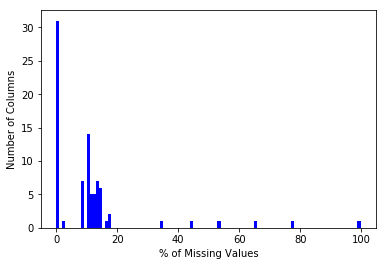

In [9]:
# Investigate patterns in the amount of missing data in each column.

percentage_null = (azdias_clean.isnull().sum()/len(azdias_clean))*100

plt.hist(percentage_null, bins=100, color='blue')
plt.ylabel('Number of Columns')
plt.xlabel('% of Missing Values')

In [10]:
percentage_null.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [11]:
print('Number of columns without missing values: {}'.format(len(percentage_null[percentage_null==0])))
print('Number of columns with percentage of missing values less or equal to 20: {}'.format(len(percentage_null[(percentage_null<=20) \
                                                                                            & (percentage_null!=0)])))
print('Number of columns with percentage of missing values greater than 20: {}'.format(len(percentage_null[percentage_null>20])))


Number of columns without missing values: 24
Number of columns with percentage of missing values less or equal to 20: 55
Number of columns with percentage of missing values greater than 20: 6


In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Drop columns with percentage of missing values greater than 20
columns_to_drop = percentage_null[percentage_null>20].index.tolist()
azdias_clean = azdias_clean.drop(columns_to_drop, axis=1)


In [13]:
columns_to_drop

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [14]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Of the 85 columns in the dataset, 24 have no missing values and 61 have at least one missing value. Therefore, most columns have missing values.

There are 55 columns with percentage of missing values less or equal to 20 and 6 columns with percentage of missing values greater than 20 - these were defined as outliers and removed from the dataset . Below is the list of columns that were removed:


     'AGER_TYP',
     'GEBURTSJAHR',
     'TITEL_KZ',
     'ALTER_HH',
     'KK_KUNDENTYP',
     'KBA05_BAUMAX'


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0.5,0,'Missing Values')

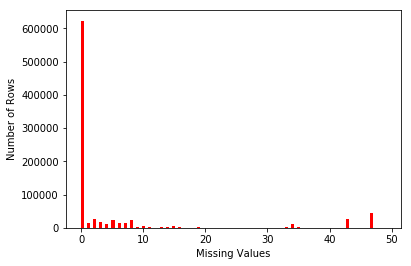

In [15]:
# How much data is missing in each row of the dataset?

null_values_rows = azdias_clean.isnull().sum(axis=1)

plt.hist(null_values_rows, bins=100, color='red')
plt.ylabel('Number of Rows')
plt.xlabel('Missing Values')

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missing_lt_30 = azdias_clean[null_values_rows<30]
missing_mt_30 = azdias_clean[null_values_rows>=30]

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns_to_compare = percentage_null[percentage_null==0].index.tolist()
columns_to_compare

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [18]:
def plot_comparison(cols):
            plots = len(cols)
            fig, axs = plt.subplots(nrows=plots, ncols=2, figsize = (15,20),squeeze=False)
            fig.subplots_adjust(hspace = 1, wspace=.3)
            
            axs[0][0].set_title('Subset with few or no missing values')
            axs[0][1].set_title('Subset with many missing values')

            for i in range(plots):
                sns.countplot(missing_lt_30[cols[i]], ax=axs[i][0])
                sns.countplot(missing_mt_30[cols[i]], ax=axs[i][1])
            

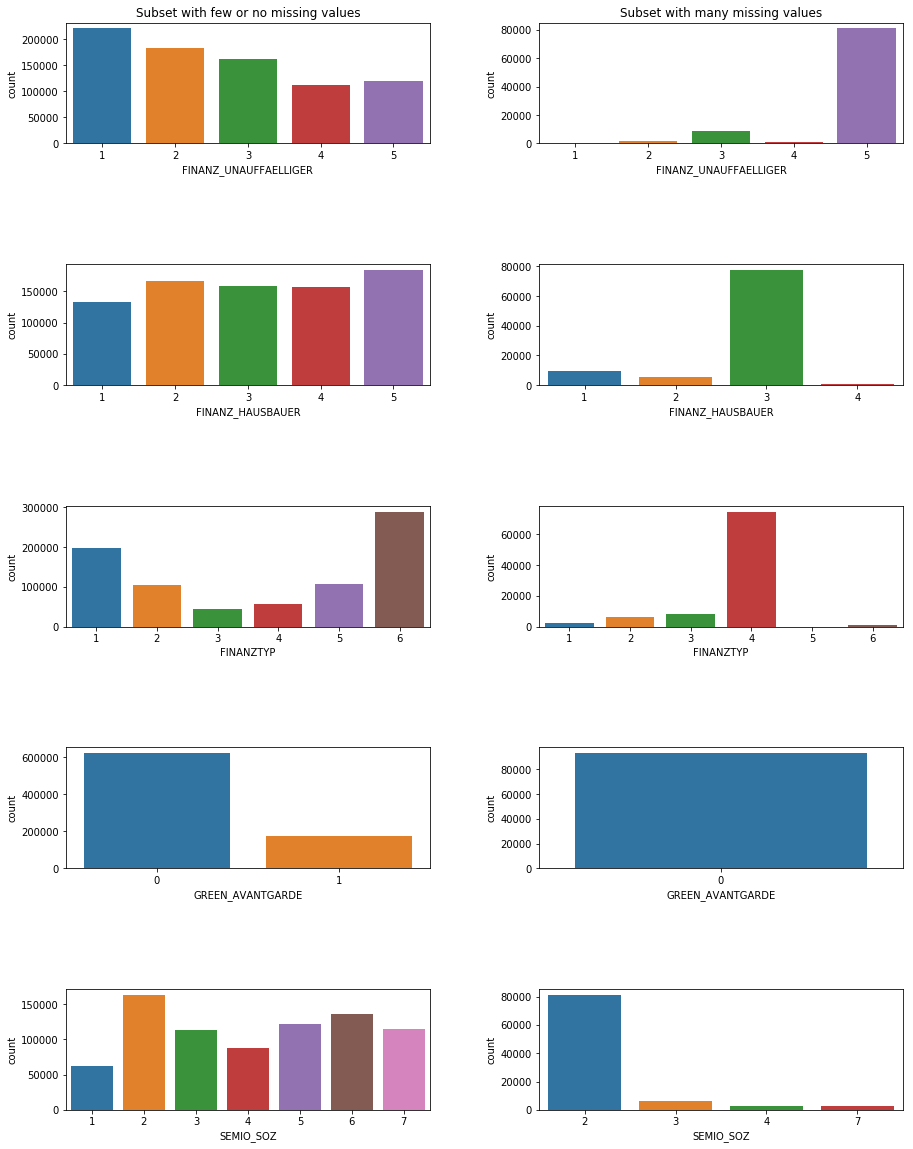

In [19]:
plot_comparison(columns_to_compare[5:10])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Most of the rows have less than 30 missing values. Thus, rows with more than 30 missing values were considered outliers.

Based on the charts above, we can see that the data distribution of the subset with many missing values (more than 30) looks very different from the data distribution of the subset with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
feat_info_subset = feat_info_new.loc[azdias_clean.columns]
feat_info_subset['type'].value_counts()


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
list_categorical_features = feat_info_subset[feat_info_subset['type']=='categorical'].index.tolist()
list_categorical_features

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [22]:
azdias_subset = missing_lt_30.copy()
unique = azdias_subset[list_categorical_features].nunique().sort_values()
unique

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [23]:
# select multi-category features:

list_multi_category = unique[unique>2].index.tolist()
print('Multi-category features: ' + str(list_multi_category))

Multi-category features: ['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'FINANZTYP', 'ZABEOTYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.

###OST_WEST_KZ is the binary variable that takes on non-numeric values and needs to be re-encoded

azdias_subset = pd.get_dummies(azdias_subset, 
                              columns=['OST_WEST_KZ'],
                              prefix='OST_WEST_KZ',
                              drop_first=True)

azdias_subset['OST_WEST_KZ_W'] = pd.to_numeric(azdias_subset['OST_WEST_KZ_W'])

In [25]:
# Drop multi-category features

azdias_subset = azdias_subset.drop(list_multi_category,axis=1)

In [26]:
initial = len(list_categorical_features)
final = initial - len(list_multi_category)
print('Initial number of categorical features: {}'.format(initial))
print('Selected number of categorical features: {}'.format(final))

Initial number of categorical features: 18
Selected number of categorical features: 5


#### Discussion 1.2.1: Re-Encode Categorical Features


Decisions made:
    
    1. Kept all binary categorical features
    
    2. Created a dummy variable from OST_WEST_KZ column
    
    3. Removed all multi-category features: ['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'FINANZTYP', 'ZABEOTYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# create binary value for movement ( 0 or 1)
azdias_subset['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias_subset['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 
                                                                                    0 if x in (1,3,5,8,10,12,14) else x/x)

# create  interval-type variable for decade

bins_ = (0,2,4,7,9,13,15,np.inf)
labels_ = (1,2,3,4,5,6,7) #(40s,50s,60s,70s,80s,90s)
azdias_subset['PRAEGENDE_JUGENDJAHRE_DECADES'] = pd.cut(azdias_subset['PRAEGENDE_JUGENDJAHRE'],bins = bins_, labels = labels_ )
azdias_subset['PRAEGENDE_JUGENDJAHRE_DECADES'] = pd.to_numeric(azdias_subset['PRAEGENDE_JUGENDJAHRE_DECADES'])



In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_subset['CAMEO_INTL_2015_WEALTH'] = pd.to_numeric(azdias_subset['CAMEO_INTL_2015'].str[0])
azdias_subset['CAMEO_INTL_2015_LIFE_STAGE'] = pd.to_numeric(azdias_subset['CAMEO_INTL_2015'].str[-1])


azdias_subset[['CAMEO_INTL_2015','CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFE_STAGE']].head(5)

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0


In [29]:
list_mixed_features = feat_info_subset[feat_info_subset['type']=='mixed'].index.tolist()

print('Mixed-type columns to be removed: ' + str(list_mixed_features))

azdias_subset = azdias_subset.drop(list_mixed_features,axis=1)


Mixed-type columns to be removed: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


#### Discussion 1.2.2: Engineer Mixed-Type Features



Decisions made:
       
       1. Created two new variables from PRAEGENDE_JUGENDJAHRE:
                a. 'PRAEGENDE_JUGENDJAHRE_MOV': binary variable to capture movement
                b. 'PRAEGENDE_JUGENDJAHRE_DECADES': interval-type variable for decade
                
        2. Engineered two new variables from CAMEO_INTL_2015:
                a. 'CAMEO_INTL_2015_WEALTH': integer variable to capture wealth
                b. 'CAMEO_INTL_2015_LIFE_STAGE': integer variable to capture life stage
                
        3. Dropped the others mixed-type featues


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print('Initial dataset contains {} columns'.format(len(feat_info_new)))

print('Final subset contains {} columns'.format(len(azdias_subset.columns)))

Initial dataset contains 85 columns
Final subset contains 64 columns


In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_subset.columns

#final subset only has the columns that I want to keep

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    for i in df.columns:
        df[i].replace(feat_info_new.loc[i,'missing_or_unknown_list'], np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    
    #  a) remove columns with many missing values
    columns_to_drop = ['AGER_TYP',
                     'GEBURTSJAHR',
                     'TITEL_KZ',
                     'ALTER_HH',
                     'KK_KUNDENTYP',
                     'KBA05_BAUMAX']
    df = df.drop(columns_to_drop, axis=1)

    #  b) remove rows with many missing values
    null_values_rows = df.isnull().sum(axis=1)
    df = df[null_values_rows<30]

    
    # select, re-encode, and engineer column values.
    
    #  a) create dummy variable for column OST_WEST_KZ
    
    df = pd.get_dummies(df, 
                        columns=['OST_WEST_KZ'],
                        prefix='OST_WEST_KZ',
                        drop_first=True)
    
    #  b) remove multi-category features
    
    df = df.drop(list_multi_category,axis=1)
    
    #  c) engineer two new variables from PRAEGENDE_JUGENDJAHRE_MOV
    
    df['PRAEGENDE_JUGENDJAHRE_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 0 if x in (1,3,5,8,10,12,14) else x/x)
    df['PRAEGENDE_JUGENDJAHRE_DECADES'] = pd.cut(df['PRAEGENDE_JUGENDJAHRE'],bins = bins_, labels = labels_ )
    
    #  d) engineer two new variables from CAMEO_INTL_2015

    df['CAMEO_INTL_2015_WEALTH'] = pd.to_numeric(df['CAMEO_INTL_2015'].str[0])
    df['CAMEO_INTL_2015_LIFE_STAGE'] = pd.to_numeric(df['CAMEO_INTL_2015'].str[-1])
    
    #  e) Drop Mixed-type columns
    
    df = df.drop(list_mixed_features,axis=1)

    # Return the cleaned dataframe.
    
    return df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print('Total number of rows: {}'.format(len(azdias_subset)))
null_values = len(azdias_subset[azdias_subset.isnull().any(axis=1)==True])
print('Total number of rows with at least one null value: {}'.format(null_values))

# applying Imputer to replace missing values

from sklearn.preprocessing import Imputer

imp_strategy = Imputer(strategy='most_frequent')
azdias_subset_clean = pd.DataFrame(imp_strategy.fit_transform(azdias_subset))
azdias_subset_clean.columns = azdias_subset.columns
azdias_subset_clean.head(10)
print('\nResults after cleaning null values:')
azdias_subset_clean.info()

Total number of rows: 798061
Total number of rows with at least one null value: 174850

Results after cleaning null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798061 entries, 0 to 798060
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB             798061 non-null float64
ANREDE_KZ                        798061 non-null float64
FINANZ_MINIMALIST                798061 non-null float64
FINANZ_SPARER                    798061 non-null float64
FINANZ_VORSORGER                 798061 non-null float64
FINANZ_ANLEGER                   798061 non-null float64
FINANZ_UNAUFFAELLIGER            798061 non-null float64
FINANZ_HAUSBAUER                 798061 non-null float64
GREEN_AVANTGARDE                 798061 non-null float64
HEALTH_TYP                       798061 non-null float64
RETOURTYP_BK_S                   798061 non-null float64
SEMIO_SOZ                        798061 non-null float64
SEMIO_FAM                        798061 non-null float64
SEMIO_REL               

In [34]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_subset_clean), columns = azdias_subset_clean.columns)
azdias_scaled.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_MOV,PRAEGENDE_JUGENDJAHRE_DECADES,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,1.455847,0.574305,-0.171400,-0.127041,0.684882,0.517426,-0.530409,1.098070,1.175657,-1.248894
1,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,0.419740,0.574305,-0.171400,-0.127041,-0.789027,0.517426,1.885336,1.098070,-0.869680,0.767095
2,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.616366,0.574305,-1.173149,-0.997549,-0.052072,0.517426,-0.530409,-0.267778,-1.551459,-0.576897
3,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,-0.616366,-0.337195,0.830348,0.308213,1.421837,0.517426,-0.530409,-0.267778,0.493878,0.095099
4,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,1.455847,1.485805,-1.173149,-0.997549,-0.052072,0.517426,-0.530409,-1.633627,1.175657,0.767095


### Discussion 2.1: Apply Feature Scaling

Decisions made:

    1. Replaced missing values using Imputer method and 'most frequent' strategy. Even though the features contain numerical values, most of them are actually representing categories. Therefore, using the 'most frequent' strategy is reasonable in this context.
    
    2. Applied feature scaling using StandardScaler method (scaling each feature to mean 0 and standard deviation 1). It's important to scale the features to ensure consistent clustering.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [35]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

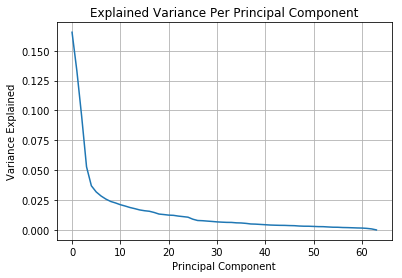

In [36]:
# Investigate the variance accounted for by each principal component.

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance Per Principal Component')
plt.grid();

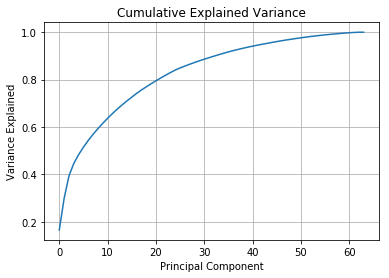

In [37]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Cumulative Explained Variance')
plt.grid();

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca35 = PCA(n_components=35)
azdias_pca = pca35.fit_transform(azdias_scaled)

In [39]:
np.sum(pca35.explained_variance_ratio_)

0.91110922678964701

### Discussion 2.2: Perform Dimensionality Reduction

Based on the charts above, I decided to retain 35 components which explain more than 90% of variance while reducing the numbers of features by more than 50% 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [40]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def feature_weights(x,i):
    df = pd.DataFrame(x.components_ , columns = azdias_scaled.columns)
    df = df.iloc[i].sort_values(ascending=False)
    return df



print(feature_weights(pca35,0).head(20))
print('\n')
print(feature_weights(pca35,0).tail(20))

PLZ8_ANTG3                       0.225345
PLZ8_ANTG4                       0.216873
CAMEO_INTL_2015_WEALTH           0.204628
HH_EINKOMMEN_SCORE               0.202187
ORTSGR_KLS9                      0.196765
EWDICHTE                         0.194654
FINANZ_HAUSBAUER                 0.159510
KBA05_ANTG4                      0.153988
PLZ8_ANTG2                       0.153685
FINANZ_SPARER                    0.153109
ARBEIT                           0.142565
KBA05_ANTG3                      0.136723
ANZ_HAUSHALTE_AKTIV              0.136056
RELAT_AB                         0.134948
SEMIO_PFLICHT                    0.121171
SEMIO_REL                        0.118599
PRAEGENDE_JUGENDJAHRE_DECADES    0.112256
SEMIO_RAT                        0.099580
SEMIO_TRADV                      0.093724
SEMIO_MAT                        0.082442
Name: 0, dtype: float64


WOHNDAUER_2008               -0.061243
KBA13_ANZAHL_PKW             -0.073929
SEMIO_LUST                   -0.076894
ANZ_PERSONEN     

In [41]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(feature_weights(pca35,1).head(20))
print('\n')
print(feature_weights(pca35,1).tail(20))

ALTERSKATEGORIE_GROB      0.256265
SEMIO_ERL                 0.229915
FINANZ_VORSORGER          0.229239
SEMIO_LUST                0.180110
RETOURTYP_BK_S            0.161878
FINANZ_HAUSBAUER          0.121830
SEMIO_KRIT                0.117850
SEMIO_KAEM                0.116437
W_KEIT_KIND_HH            0.114740
PLZ8_ANTG3                0.098404
EWDICHTE                  0.097909
ORTSGR_KLS9               0.096589
PLZ8_ANTG4                0.096257
ANREDE_KZ                 0.093140
CAMEO_INTL_2015_WEALTH    0.079218
KBA05_ANTG4               0.075239
SEMIO_DOM                 0.074492
ARBEIT                    0.071835
RELAT_AB                  0.069307
PLZ8_ANTG2                0.068172
Name: 1, dtype: float64


KBA05_ANTG1                     -0.074407
KONSUMNAEHE                     -0.074798
PLZ8_GBZ                        -0.075153
INNENSTADT                      -0.079661
MOBI_REGIO                      -0.080841
KBA05_GBZ                       -0.092366
PLZ8_ANTG1            

In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(feature_weights(pca35,2).head(20))
print('\n')
print(feature_weights(pca35,2).tail(20))


SEMIO_VERT                   0.344664
SEMIO_SOZ                    0.261932
SEMIO_FAM                    0.248836
SEMIO_KULT                   0.233936
FINANZ_MINIMALIST            0.154493
RETOURTYP_BK_S               0.108975
FINANZ_VORSORGER             0.101711
W_KEIT_KIND_HH               0.085079
ALTERSKATEGORIE_GROB         0.079618
SEMIO_REL                    0.067673
SEMIO_LUST                   0.064452
SEMIO_MAT                    0.055671
ORTSGR_KLS9                  0.050284
EWDICHTE                     0.049493
PLZ8_ANTG4                   0.049205
PLZ8_ANTG3                   0.048410
GREEN_AVANTGARDE             0.047104
PRAEGENDE_JUGENDJAHRE_MOV    0.047104
ARBEIT                       0.037364
RELAT_AB                     0.034366
Name: 2, dtype: float64


HEALTH_TYP                      -0.034073
BALLRAUM                        -0.037239
FINANZ_HAUSBAUER                -0.039724
KONSUMNAEHE                     -0.040451
PLZ8_GBZ                        -0.040540
INNE

### Discussion 2.3: Interpret Principal Components


###### 1. First component:
   
    a. Top positive correlations:
        - PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region                      
        - PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region                     
        - CAMEO_INTL_2015_WEALTH: How wealth the household is (where 1 = wealthy household and 5 = poorer household)
        
    b. Top negative correlations:

        - PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region   
        - MOBI_REGIO: Movement patterns (where 1 = very high movement and 6 = none)               
        - FINANZ_MINIMALIST: Low financial interest (where 1 = very high and 5 = very low)  
        
    c. Interpretation: 
            
         When the proportion of the number of 6-10 family homes (PLZ8_ANTG3) increases, the proportion of the number of 10 or more family homes (PLZ8_ANTG4) also increases and the wealth level (CAMEO_INTL_2015_WEALTH) of the households tends to be poorer. The increase of any of these 3 variables results in a decrease of the variables PLZ8_ANTG1, MOBI_REGIO and FINANZ_MINIMALIST. Thus, this means a lower proportion of number of 1-2 family houses, lower financial interest and higher movement patterns. 
    
        
        
###### 2. Second component:

    a. Top positive correlations:
    
        ALTERSKATEGORIE_GROB: Estimated age based on given name analysis (where 1 = < 30 years old and 4 = > 60 years old)
        SEMIO_ERL: Event-oriented (where 1 = highest affinity and 7 = lowest affinity)         
        FINANZ_VORSORGER: Be prepared (financial type) (where 1 = very high and 5 = very low)  
        
    b. Top negative correlations:
    
        SEMIO_REL: Religious (where 1 = highest affinity and 7 = lowest affinity) 
        PRAEGENDE_JUGENDJAHRE_DECADES: Generation by decade
        FINANZ_SPARER: Money-saver (where 1 = very high and 5 = very low)                    
         
    c. Interpretation:
            
            When the estimated age based on given name increases (ALTERSKATEGORIE_GROB), the affinity to events (SEMIO_ERL) and the financial type "be prepared" (FINANZ_VORSORGER) tends be lower ( N.B: high numbers for these features means low affinity/level). The increase of any of these 3 variables results in a decrease of the variables SEMIO_REL, PRAEGENDE_JUGENDJAHRE_DECADES, FINANZ_SPARER. This means that the religious affinity tends bo higher, greater chances to be a "Money-saver" financial type and belonging to the 40s decade generation. 
            
                      
    
    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts...

    # run k-means clustering on the data and...

def get_scores(data,n):
    model = KMeans(n).fit(data)
    score = np.abs(model.score(data))
    
    return score

    # compute the average within-cluster distances.
    
def score_comparison(data):
    scores = []
    centers = list(range(1,20))
    
    for n in centers:
        scores.append(get_scores(data,n))
        
    return centers, scores



In [44]:
centers, scores = score_comparison(azdias_pca)

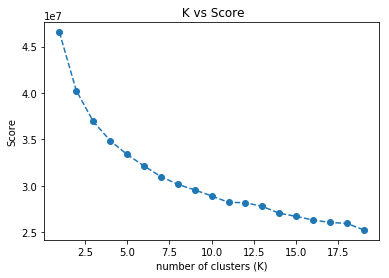

In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers,scores,marker='o',linestyle='--')
plt.xlabel('number of clusters (K)')
plt.ylabel('Score')
plt.title(" K vs Score")
plt.show()

In [46]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model_12 = KMeans(12).fit(azdias_pca)

pred=model_12.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Based on the elbow method (locating a bend in the plot), I decided to segment the population in 12 clusters. Adding more clusters wouldn't significantly improve the model score.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [48]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# a) Applying preprocessing steps
customers_pre = clean_data(customers)

print(customers_pre.shape)
print(azdias_subset.shape)

(141725, 64)
(798061, 64)


In [49]:
# b) Applying Imputer to replace missing values

customers_clean = pd.DataFrame(imp_strategy.transform(customers_pre))
customers_clean.columns = customers_pre.columns
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141725 entries, 0 to 141724
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB             141725 non-null float64
ANREDE_KZ                        141725 non-null float64
FINANZ_MINIMALIST                141725 non-null float64
FINANZ_SPARER                    141725 non-null float64
FINANZ_VORSORGER                 141725 non-null float64
FINANZ_ANLEGER                   141725 non-null float64
FINANZ_UNAUFFAELLIGER            141725 non-null float64
FINANZ_HAUSBAUER                 141725 non-null float64
GREEN_AVANTGARDE                 141725 non-null float64
HEALTH_TYP                       141725 non-null float64
RETOURTYP_BK_S                   141725 non-null float64
SEMIO_SOZ                        141725 non-null float64
SEMIO_FAM                        141725 non-null float64
SEMIO_REL                        141725 non-null float64
SEMIO_MAT                        141725 non-null float64
SEMIO_VERT                       1

In [50]:
# c) Applying feature scaling 
customers_scaled = pd.DataFrame(scaler.transform(customers_clean), columns = customers_clean.columns)

customers_scaled.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_MOV,PRAEGENDE_JUGENDJAHRE_DECADES,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,1.184106,-1.043935,1.409057,-1.155518,1.138172,-1.249985,-0.470407,-0.791205,1.885336,-1.633796,...,1.455847,1.485805,-2.174897,-1.432803,-1.525981,0.517426,1.885336,-1.633627,-1.551459,0.095099
1,1.184106,0.957914,1.409057,-1.155518,1.138172,-1.249985,0.958645,0.629141,1.885336,-0.311816,...,-0.616366,-1.248695,-0.171400,-0.127041,-0.052072,0.517426,1.885336,-1.633627,-0.187901,0.767095
2,1.184106,-1.043935,1.409057,-1.155518,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.616366,0.574305,-2.174897,-0.997549,-1.525981,0.517426,-0.530409,-2.316552,-0.869680,0.767095
3,0.200522,-1.043935,-0.042768,-1.155518,0.411884,0.786978,1.673172,-0.791205,-0.530409,1.010164,...,-0.616366,-0.337195,-0.171400,-0.127041,-1.525981,0.517426,-0.530409,-0.267778,0.493878,-1.248894
4,0.200522,-1.043935,1.409057,-1.155518,1.138172,-1.249985,-0.470407,-0.081032,1.885336,1.010164,...,1.455847,1.485805,-0.171400,0.743466,1.421837,0.517426,1.885336,-1.633627,-0.187901,0.767095


In [51]:
# d) Applying PCA transformation

customers_pca = pca35.transform(customers_scaled)

In [52]:
# e) Obtaining clusters

customers_pred = model_12.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

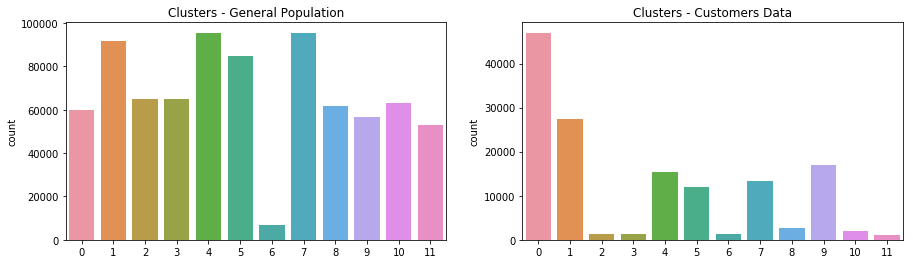

In [53]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def compare_plot(general,customers):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('Clusters - General Population')
    sns.countplot(general,ax=ax1)

    ax2.set_title('Clusters - Customers Data')
    sns.countplot(customers,ax=ax2)
    plt.show()
    
compare_plot(pred,customers_pred)

In [56]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid = scaler.inverse_transform(pca35.inverse_transform(model_12.cluster_centers_[0]))

overrepresented = pd.DataFrame ( {"feature":customers_clean.columns,"centroid_0": centroid })


pd.concat([overrepresented.head(32).reset_index(drop=True), overrepresented.tail(32).reset_index(drop=True)], axis=1)

,feature,centroid_0,feature,centroid_0
0,ALTERSKATEGORIE_GROB,3.291267,ANZ_HAUSHALTE_AKTIV,1.769299
1,ANREDE_KZ,1.050420,ANZ_HH_TITEL,0.021722
2,FINANZ_MINIMALIST,4.798363,KONSUMNAEHE,3.347926
3,FINANZ_SPARER,1.670605,MIN_GEBAEUDEJAHR,1992.967758
4,FINANZ_VORSORGER,4.153057,KBA05_ANTG1,2.626186
5,FINANZ_ANLEGER,1.537145,KBA05_ANTG2,1.103764
6,FINANZ_UNAUFFAELLIGER,2.197156,KBA05_ANTG3,0.081107
7,FINANZ_HAUSBAUER,1.914093,KBA05_ANTG4,0.009753
8,GREEN_AVANTGARDE,0.990371,KBA05_GBZ,4.041544
9,HEALTH_TYP,2.084784,BALLRAUM,4.014177


In [63]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid = scaler.inverse_transform(pca35.inverse_transform(model_12.cluster_centers_[3]))

underrepresented  = pd.DataFrame ( {"feature":customers_clean.columns,"centroid_3": centroid })

pd.concat([underrepresented.head(32).reset_index(drop=True), underrepresented.tail(32).reset_index(drop=True)], axis=1)

,feature,centroid_3,feature,centroid_3
0,ALTERSKATEGORIE_GROB,1.878755,ANZ_HAUSHALTE_AKTIV,7.046885
1,ANREDE_KZ,1.964697,ANZ_HH_TITEL,0.023094
2,FINANZ_MINIMALIST,1.423886,KONSUMNAEHE,2.674780
3,FINANZ_SPARER,4.229543,MIN_GEBAEUDEJAHR,1992.825120
4,FINANZ_VORSORGER,2.332028,KBA05_ANTG1,0.907381
5,FINANZ_ANLEGER,4.308923,KBA05_ANTG2,1.997719
6,FINANZ_UNAUFFAELLIGER,3.875957,KBA05_ANTG3,0.965631
7,FINANZ_HAUSBAUER,3.906764,KBA05_ANTG4,0.174961
8,GREEN_AVANTGARDE,0.067457,KBA05_GBZ,2.890414
9,HEALTH_TYP,2.449975,BALLRAUM,4.290096


### Discussion 3.3: Compare Customer Data to Demographics Data


1. The **segment 0 is overrepresented** in the customers data, which means it's a popular segment with the mail-oder company. Some characteristics of this segment are:
        a. Predominant male (ANREDE_KZ = 1.05042)
        b. Mainly between 46-60 years old (ALTERSKATEGORIE_GROB = 3.291267)
        c. Combative attitude (SEMIO_KAEM = 2.634931)
        d. Not dreamful (SEMIO_VERT = 6.233379)
        e. Investor type and money saver (FINANZ_SPARER = 1.670605 and FINANZ_ANLEGER = 1.537145)
        f. Life stage: "Families With School Age Children" (CAMEO_INTL_2015_LIFE_STAGE = 3.581906)
        
     

2. The **segment 3 is underrpresented** in the customers data, which means it's an unpopular segment with the mail-oder company. Some characteristics of this segment are:
        a. Predominant female (ANREDE_KZ = 1.964697)
        b. Less than 45 years old (ALTERSKATEGORIE_GROB = 1.878755)
        c. Low financial interest (FINANZ_MINIMALIST = 1.423886)
        c. Not dominant-minded (SEMIO_DOM = 5.963737)
        d. Dreamful (SEMIO_VERT = 2.363152)
        e. Comfortable/Less Affluent Households  (CAMEO_INTL_2015_WEALTH = 3.661343)
        f. Life stage: "Young Couples With Children" (CAMEO_INTL_2015_LIFE_STAGE = 2.619409)       
        

We can see that the characteristics of segments 0 and 3 are basically opposite to each other. So if segment 0 is popular, we expect segment 3 to be unpopular.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.